## Importando DS e bibliotecas

In [73]:
!wget "https://github.com/augustolnb/LAMIA/raw/refs/heads/main/bootcamp/card28/dataset-dental-floss.zip"

--2025-08-08 14:45:54--  https://github.com/augustolnb/LAMIA/raw/refs/heads/main/bootcamp/card28/dataset-dental-floss.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/augustolnb/LAMIA/refs/heads/main/bootcamp/card28/dataset-dental-floss.zip [following]
--2025-08-08 14:45:55--  https://raw.githubusercontent.com/augustolnb/LAMIA/refs/heads/main/bootcamp/card28/dataset-dental-floss.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21210526 (20M) [application/zip]
Saving to: ‘dataset-dental-floss.zip.2’

dataset-dental-flos 100%[===================>]  20.23M  --.-KB/s    in 0.07s   

2025-0

In [ ]:
!mkdir /content/ds

In [ ]:
!unzip /content/dataset-dental-floss.zip -d /content/ds

In [76]:
import os
import cv2
import zipfile
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [77]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [78]:
# Caminho do dataset

dataset_dir = pathlib.Path('/content/ds/')

# Parâmetros das imagens
image_size = (128, 128)
batch_size = 32

## Preparação dos dados

In [79]:
# Dividir dataset

# Conjunto de Treino (75%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='binary',
    validation_split=0.25,  # 25% do dataset para validação e teste
    subset='training',
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale'
)

# Conjunto de Validação (15%) e Teste (10%)
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='binary',
    validation_split=0.25,
    subset='validation',
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale'
)

Found 4066 files belonging to 2 classes.
Using 3050 files for training.
Found 4066 files belonging to 2 classes.
Using 1016 files for validation.


In [80]:
# Normalizar as imagens

normalizacao = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalizacao(x), y))
val_ds = val_ds.map(lambda x, y: (normalizacao(x), y))

In [81]:
# Dividir validação e teste
# 'val_ds' tem 25% dos dados.
# 60% de 25% = 15% do total
# 40% de 25% = 10% do total

val_batches = tf.data.experimental.cardinality(val_ds)

test_ds = val_ds.take(tf.cast(tf.cast(val_batches, tf.float32) * 0.4, tf.int64))
val_ds = val_ds.skip(tf.cast(tf.cast(val_batches, tf.float32) * 0.4, tf.int64))

In [82]:
# Verificando os conjuntos

print(f"Número de lotes de treinamento: {tf.data.experimental.cardinality(train_ds)}")
print(f"Número de lotes de validação: {tf.data.experimental.cardinality(val_ds)}")
print(f"Número de lotes de teste: {tf.data.experimental.cardinality(test_ds)}")

Número de lotes de treinamento: 96
Número de lotes de validação: 20
Número de lotes de teste: 12


In [83]:
# Configuração para desempenho
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [84]:
# data augmentation para o conjunto de treino
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),  # espelhamento horizontal
    layers.RandomContrast(0.2)       # variação de contraste
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [85]:
num_classes = 2

# Testes

## 1. Modelo sem Dropout

In [ ]:
model = keras.Sequential([
    # camada de entrada com o formato das suas imagens (128x128)
    layers.Input(shape=(128, 128, 1)),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

## 2. Modelo com Dropout (3 camadas)

In [ ]:
model = keras.Sequential([
    layers.Input(shape=(128, 128, 1)),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),

    # camada dropout
    layers.Dropout(0.4),

    layers.Dense(num_classes)
])

## 2.1 Modelo com Dropout (4 camadas)

In [ ]:
model = keras.Sequential([
        layers.Input(shape=(128, 128, 1)),

        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(),

        # --- Quarta Camada Convolucional Adicionada ---
        layers.Conv2D(256, 3, activation='relu'),
        layers.MaxPooling2D(),
        # --------------------------------------------

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(2)
    ])

## Treino (testando os modelos)

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,567,874 (5.98 MB)

 Trainable params: 1,567,874 (5.98 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
epochs = 13

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

print("Treinamento concluído!")

Epoch 1/13
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.5256 - loss: 0.6925 - val_accuracy: 0.6361 - val_loss: 0.6261
Epoch 2/13
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6286 - loss: 0.6301 - val_accuracy: 0.7041 - val_loss: 0.5480
Epoch 3/13
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6671 - loss: 0.6054 - val_accuracy: 0.7136 - val_loss: 0.5294
Epoch 4/13
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6914 - loss: 0.5836 - val_accuracy: 0.7373 - val_loss: 0.4976
Epoch 5/13
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7176 - loss: 0.5428 - val_accuracy: 0.7642 - val_loss: 0.4611
Epoch 6/13
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7533 - loss: 0.4962 - val_accuracy: 0.8038 - val_loss: 0.4330
Epoch 7/13
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7827 - loss: 0.4614 - val_accuracy: 0.7991 - val_loss: 0.4210
Epoch 8/13
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7981 - loss: 0.4413 - val_accuracy: 0.8006 - 

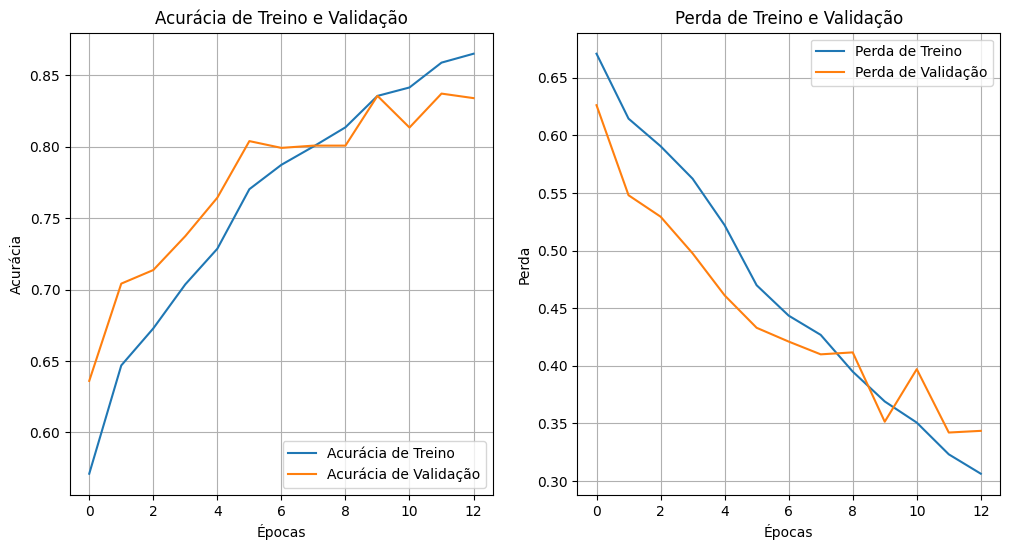


--- Resultados Finais ---
Acurácia final de Treino: 0.8649
Acurácia final de Validação: 0.8339
Perda final de Treino: 0.3064
Perda final de Validação: 0.3436


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']  # Acurácia do conjunto de validação
loss = history.history['loss']
val_loss = history.history['val_loss']    # Perda do conjunto de validação

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# --- Gráfico de Acurácia ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treino')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.grid(True)

# --- Gráfico de Perda (Loss) ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda de Treino')
plt.plot(epochs_range, val_loss, label='Perda de Validação')
plt.legend(loc='upper right')
plt.title('Perda de Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.grid(True)

plt.show()

# Exibe os valores finais de acurácia e perda
final_acc = acc[-1]
final_val_acc = val_acc[-1]
final_loss = loss[-1]
final_val_loss = val_loss[-1]

print("\n--- Resultados Finais ---")
print(f"Acurácia final de Treino: {final_acc:.4f}")
print(f"Acurácia final de Validação: {final_val_acc:.4f}")
print(f"Perda final de Treino: {final_loss:.4f}")
print(f"Perda final de Validação: {final_val_loss:.4f}")

## Predição

In [ ]:

def prever_nova_imagem(caminho_imagem, model):

    img = cv2.imread(caminho_imagem, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"Erro: Não foi possível carregar a imagem em {caminho_imagem}")
        return None, None

    # redimensionar para 128x128
    img_resized = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)

    # normalizar
    img_normalized = img_resized.astype("float32") / 255.0

    # ajustar as dimensões para o modelo
    img_tensor = np.expand_dims(img_normalized, axis=-1)
    img_tensor = np.expand_dims(img_tensor, axis=0)

    # fazer a predição
    predictions = model.predict(img_tensor)

    # índice da classe de maior probabilidade
    predicted_class_index = np.argmax(predictions, axis=1)

    # usando os logits para calcular a probabilidade
    probabilities = tf.nn.softmax(predictions).numpy()[0]

    class_names = ['empty', 'full']
    predicted_class = class_names[predicted_class_index[0]]

    return predicted_class, probabilities


In [ ]:
caminho_da_nova_imagem = '/content/dental12.png'

classe_predita, probabilidades = prever_nova_imagem(caminho_da_nova_imagem, model)

if classe_predita:
    print("\n--- Resultado da Predição ---")
    print(f"A imagem é provavelmente: {classe_predita}")
    print(f"Probabilidade de ser 'empty': {probabilidades[0]:.2f}")
    print(f"Probabilidade de ser 'full': {probabilidades[1]:.2f}")

## 1ºª Avaliação das Métricas

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
y_true = []
y_pred_logits = []

# Obtendo rótulos e previsões
for images, labels in test_ds:
    # rótulos reais
    y_true.extend(labels.numpy())

    predictions = model.predict(images, verbose=0)
    y_pred_logits.extend(predictions)

y_pred = np.argmax(y_pred_logits, axis=1)

# matriz confusão
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# acurácia, precisão e recall
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

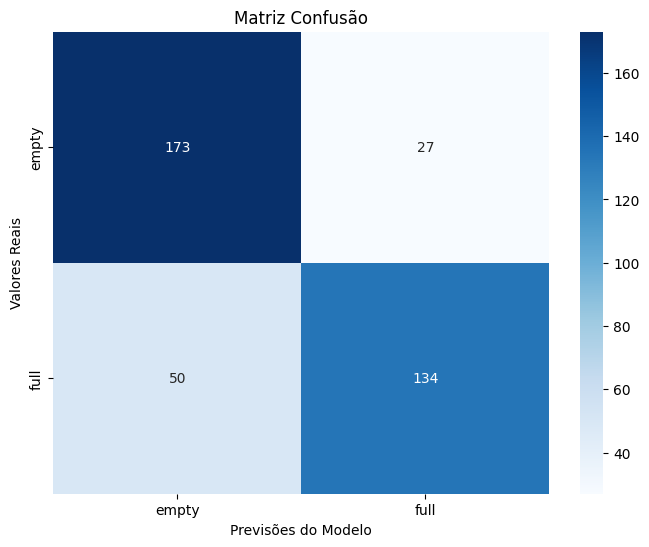


--- Resultados Matriz Confusão ---
Verdadeiros Positivos (VP - Previsão 'full' correta): 134
Verdadeiros Negativos (VN - Previsão 'empty' correta): 173
Falsos Positivos (FP - Previsão 'full' incorreta): 27
Falsos Negativos (FN - Previsão 'empty' incorreta): 50

--- Métricas de Avaliação ---
Acurácia: 0.7995
Precisão (para a classe 'full'): 0.8323
Recall (para a classe 'full'): 0.7283


In [ ]:
class_names = ['empty', 'full']

plt.figure(figsize=(8, 6))
sns.heatmap(cm,
            annot=True,          # Mostra os valores na matriz
            fmt='d',             # Formato dos números (inteiro)
            cmap='Blues',        # Mapa de cores
            xticklabels=class_names,  # Rótulos do eixo X (Previsões)
            yticklabels=class_names)  # Rótulos do eixo Y (Valores Reais)

plt.xlabel('Previsões do Modelo')
plt.ylabel('Valores Reais')
plt.title('Matriz Confusão')
plt.show()

print("\n--- Resultados Matriz Confusão ---")
print(f"Verdadeiros Positivos (VP - Previsão 'full' correta): {tp}")
print(f"Verdadeiros Negativos (VN - Previsão 'empty' correta): {tn}")
print(f"Falsos Positivos (FP - Previsão 'full' incorreta): {fp}")
print(f"Falsos Negativos (FN - Previsão 'empty' incorreta): {fn}")

print("\n--- Métricas de Avaliação ---")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão (para a classe 'full'): {precision:.4f}")
print(f"Recall (para a classe 'full'): {recall:.4f}")

## Aplicando Grid Search

In [ ]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
dropout_rates = [0.2, 0.25, 0.3, 0.4, 0.5]
epochs_num = [8, 10, 12, 14]

# Armazena os resultados para análise posterior
results = []
best_val_accuracy = 0
best_hyperparams = {}

In [ ]:
def create_model(learning_rate, dropout_rate):
    model = keras.Sequential([
        layers.Input(shape=(128, 128, 1)),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

In [ ]:
print("Iniciando o Grid Search...")
for lr in learning_rates:
    for dr in dropout_rates:
        for epochs in epochs_num:
            print(f"\n--- Testando: lr={lr}, dropout_rate={dr}, epochs_num={epochs} ---")

            # Construir o modelo com a combinação atual
            model = create_model(learning_rate=lr, dropout_rate=dr)

            # Treinar o modelo
            history = model.fit(
                train_ds,
                validation_data=val_ds,
                epochs=epochs,
                verbose=0
            )

            # desempenho na validação
            val_acc = history.history['val_accuracy'][-1]
            results.append({'lr': lr, 'dropout_rate': dr, 'epochs': epochs, 'val_accuracy': val_acc})

            print(f"Acurácia de validação: {val_acc:.4f}")

print("\n--- Grid Search Concluído ---")

Iniciando o Grid Search...

--- Testando: lr=0.001, dropout_rate=0.2, epochs_num=8 ---
Acurácia de validação: 0.8054

--- Testando: lr=0.001, dropout_rate=0.2, epochs_num=10 ---
Acurácia de validação: 0.8196

--- Testando: lr=0.001, dropout_rate=0.2, epochs_num=12 ---
Acurácia de validação: 0.8006

--- Testando: lr=0.001, dropout_rate=0.2, epochs_num=14 ---
Acurácia de validação: 0.7896

--- Testando: lr=0.001, dropout_rate=0.3, epochs_num=8 ---
Acurácia de validação: 0.8149

--- Testando: lr=0.001, dropout_rate=0.3, epochs_num=10 ---
Acurácia de validação: 0.8165

--- Testando: lr=0.001, dropout_rate=0.3, epochs_num=12 ---
Acurácia de validação: 0.8244

--- Testando: lr=0.001, dropout_rate=0.3, epochs_num=14 ---
Acurácia de validação: 0.7611

--- Testando: lr=0.001, dropout_rate=0.4, epochs_num=8 ---
Acurácia de validação: 0.7848

--- Testando: lr=0.001, dropout_rate=0.4, epochs_num=10 ---
Acurácia de validação: 0.8054

--- Testando: lr=0.001, dropout_rate=0.4, epochs_num=12 ---
Acurá

### 1º teste: batch size = 64

Selecionando as 4 melhores combinações de hiperparêmtros serão feitos as avaliações baseadas nas métricas de precisão e recall

1. lr:1e-3   
dropout:40%  
epochs:12  
---
2. lr:1e-3  
dropout:25%  
epochs:12  
---
3. lr:1e-3  
dropout:25%  
epochs:10
---
4. lr:1e-3  
dropout:50%  
epochs:12

In [ ]:
combinacoes_selecionadas = [
    {'label': 'Modelo 1', 'lr': 1e-3, 'dr': 0.2},
    {'label': 'Modelo 2', 'lr': 1e-3, 'dr': 0.3},
    {'label': 'Modelo 3', 'lr': 1e-3, 'dr': 0.4},
    {'label': 'Modelo 4', 'lr': 1e-3, 'dr': 0.5}
]

### 2º teste: batch size = 32

Selecionando as 4 melhores combinações de hiperparêmtros serão feitos as avaliações baseadas nas métricas de precisão e recall

1. lr:1e-3   
dropout:40%  
epochs:14  
---
2. lr:1e-3   
dropout:30%  
epochs:12  
---
3. lr:1e-4   
dropout:40%  
epochs:14  
---
4. lr:1e-3   
dropout:20%  
epochs:10  
---

Apesar das combinações apresentarem acurácia > 80%, nenhuma das combinações do 2º teste de Grid Search (batch_size=32) foi superior ao conjunto  de hiperparâmetros encontrados anteriormente.

In [ ]:
combinacoes_selecionadas = [
    {'label': 'Modelo 1', 'lr': 1e-3, 'dr': 0.4},
    {'label': 'Modelo 2', 'lr': 1e-3, 'dr': 0.3},
    {'label': 'Modelo 3', 'lr': 1e-4, 'dr': 0.4},
    {'label': 'Modelo 4', 'lr': 1e-3, 'dr': 0.2}
]

### Avaliando os parametros (learning rate, dropout)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def avalia_modelo(model, test_ds, label, lr, dr):

    print("\n-------------------------------------")
    print(f"\n {label}:")
    print(f"\n lr={lr}, dropout={dr}")

    epochs_num = [10, 11, 12, 13, 14]

    for epochs in epochs_num:
        print(f"\nTestando: epochs={epochs}")

        # treinamento
        model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            verbose=0
        )

        y_true = []
        y_pred_logits = []
        for images, labels in test_ds:
            y_true.extend(labels.numpy())
            predictions = model.predict(images, verbose=0)
            y_pred_logits.extend(predictions)

        y_pred = np.argmax(y_pred_logits, axis=1)

        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        # métricas
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        print("\n--- Resultados ")
        print(f"Acurácia: {accuracy:.4f}")
        print(f"Precisão: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print("\nMatriz de Confusão:\n", cm)


In [ ]:
for params in combinacoes_selecionadas:
    modelo = create_model(params['lr'], params['dr'])

    # Avalie o modelo
    avalia_modelo(modelo, test_ds, params['label'], params['lr'], params['dr'])


-------------------------------------

 Modelo 1:

 lr=0.001, dropout=0.4

Testando: epochs=10

--- Resultados 
Acurácia: 0.7865
Precisão: 0.7742
Recall: 0.7826

Matriz de Confusão:
 [[158  42]
 [ 40 144]]

Testando: epochs=11

--- Resultados 
Acurácia: 0.7604
Precisão: 0.9510
Recall: 0.5272

Matriz de Confusão:
 [[195   5]
 [ 87  97]]

Testando: epochs=12

--- Resultados 
Acurácia: 0.8411
Precisão: 0.8475
Recall: 0.8152

Matriz de Confusão:
 [[173  27]
 [ 34 150]]

Testando: epochs=13

--- Resultados 
Acurácia: 0.8255
Precisão: 0.8268
Recall: 0.8043

Matriz de Confusão:
 [[169  31]
 [ 36 148]]

Testando: epochs=14

--- Resultados 
Acurácia: 0.8151
Precisão: 0.8156
Recall: 0.7935

Matriz de Confusão:
 [[167  33]
 [ 38 146]]

-------------------------------------

 Modelo 2:

 lr=0.001, dropout=0.3

Testando: epochs=10

--- Resultados 
Acurácia: 0.7865
Precisão: 0.7742
Recall: 0.7826

Matriz de Confusão:
 [[158  42]
 [ 40 144]]

Testando: epochs=11

--- Resultados 
Acurácia: 0.7734
Pre

# Versão final

## Configurando o modelo final

### Modelo

In [86]:
# Valores finais dos hiperparâmetros
dropout_rate = 0.4
learning_rate = 1e-3
epochs = 13

#batch_size foi redefinido no inicio do notebook pois é utilizado para separar os dados em treino e validação

In [87]:
model = keras.Sequential([
    layers.Input(shape=(128, 128, 1)),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),

    # camada dropout
    layers.Dropout(dropout_rate),

    layers.Dense(num_classes)
])

In [88]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,322 (12.60 MB)

 Trainable params: 3,304,322 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

In [89]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

### Treinamento

In [90]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

print("Treinamento concluído!")

Epoch 1/13
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.5761 - loss: 0.6842 - val_accuracy: 0.6614 - val_loss: 0.6020
Epoch 2/13
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6485 - loss: 0.6200 - val_accuracy: 0.6772 - val_loss: 0.5882
Epoch 3/13
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6566 - loss: 0.5939 - val_accuracy: 0.7009 - val_loss: 0.5626
Epoch 4/13
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6658 - loss: 0.5877 - val_accuracy: 0.7120 - val_loss: 0.5561
Epoch 5/13
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6873 - loss: 0.5621 - val_accuracy: 0.7453 - val_loss: 0.5280
Epoch 6/13
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7395 - loss: 0.5205 - val_accuracy: 0.7579 - val_loss: 0.4926
Epoch 7/13
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7455 - loss: 0.5012 - val_accuracy: 0.7468 - val_loss: 0.4944
Epoch 8/13
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7699 - loss: 0.4771 - val_accuracy: 0.7801 - v

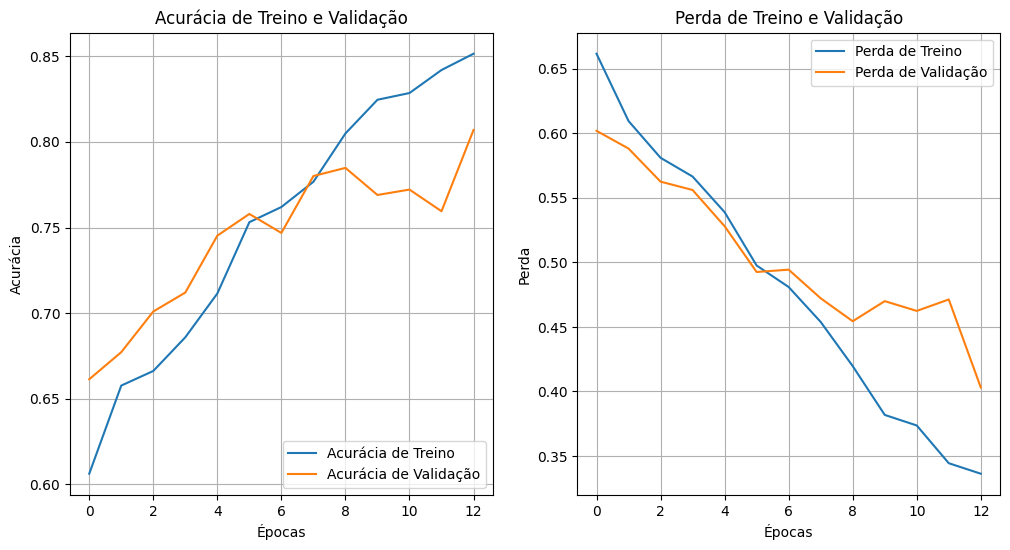


--- Resultados Finais ---
Acurácia final de Treino: 0.8515
Acurácia final de Validação: 0.8070
Perda final de Treino: 0.3362
Perda final de Validação: 0.4030


In [91]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']  # Acurácia do conjunto de validação
loss = history.history['loss']
val_loss = history.history['val_loss']    # Perda do conjunto de validação

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# --- Gráfico de Acurácia ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treino')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.grid(True)

# --- Gráfico de Perda (Loss) ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda de Treino')
plt.plot(epochs_range, val_loss, label='Perda de Validação')
plt.legend(loc='upper right')
plt.title('Perda de Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.grid(True)

plt.show()

# Exibe os valores finais de acurácia e perda
final_acc = acc[-1]
final_val_acc = val_acc[-1]
final_loss = loss[-1]
final_val_loss = val_loss[-1]

print("\n--- Resultados Finais ---")
print(f"Acurácia final de Treino: {final_acc:.4f}")
print(f"Acurácia final de Validação: {final_val_acc:.4f}")
print(f"Perda final de Treino: {final_loss:.4f}")
print(f"Perda final de Validação: {final_val_loss:.4f}")

### 2ª Avaliação das Métricas

In [92]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [93]:
y_true = []
y_pred_logits = []

for images, labels in test_ds:
    # rótulos reais
    y_true.extend(labels.numpy())
    # previsões
    predictions = model.predict(images, verbose=0)
    y_pred_logits.extend(predictions)

y_pred = np.argmax(y_pred_logits, axis=1)

# matriz confusão
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# acurácia, precisão e recall
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

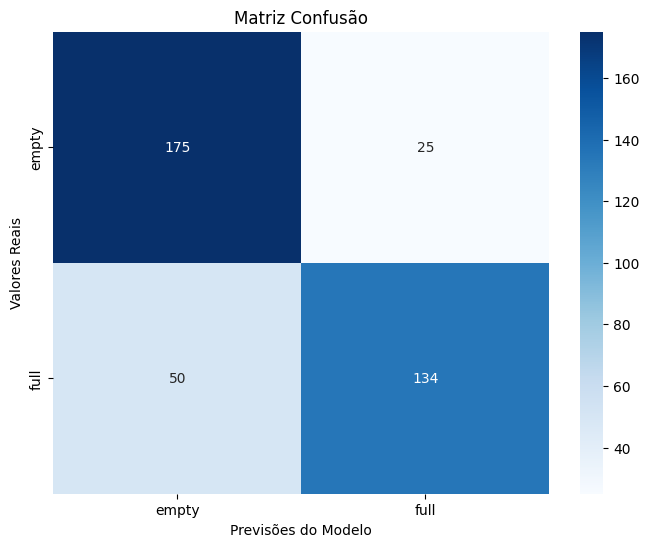


 Matriz Confusão
Verdadeiros Positivos (VP - Previsão 'full' correta): 134
Verdadeiros Negativos (VN - Previsão 'empty' correta): 175
Falsos Positivos (FP - Previsão 'full' incorreta): 25
Falsos Negativos (FN - Previsão 'empty' incorreta): 50

 Métricas 
Acurácia: 0.8047
Precisão (para a classe 'full'): 0.8428
Recall (para a classe 'full'): 0.7283


In [94]:
class_names = ['empty', 'full']

plt.figure(figsize=(8, 6))
sns.heatmap(cm,
            annot=True,          # Mostra os valores na matriz
            fmt='d',             # Formato dos números (inteiro)
            cmap='Blues',        # Mapa de cores
            xticklabels=class_names,  # Rótulos do eixo X (Previsões)
            yticklabels=class_names)  # Rótulos do eixo Y (Valores Reais)

plt.xlabel('Previsões do Modelo')
plt.ylabel('Valores Reais')
plt.title('Matriz Confusão')
plt.show()

print("\n Matriz Confusão")
print(f"Verdadeiros Positivos (VP - Previsão 'full' correta): {tp}")
print(f"Verdadeiros Negativos (VN - Previsão 'empty' correta): {tn}")
print(f"Falsos Positivos (FP - Previsão 'full' incorreta): {fp}")
print(f"Falsos Negativos (FN - Previsão 'empty' incorreta): {fn}")

print("\n Métricas ")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão (para a classe 'full'): {precision:.4f}")
print(f"Recall (para a classe 'full'): {recall:.4f}")

### Predição

In [95]:

def prever_nova_imagem(caminho_imagem, model):

    img = cv2.imread(caminho_imagem, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"Erro: Não foi possível carregar a imagem em {caminho_imagem}")
        return None, None

    img_resized = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)

    # normalização
    img_normalized = img_resized.astype("float32") / 255.0

    # ajuste de dimensões
    img_tensor = np.expand_dims(img_normalized, axis=-1)
    img_tensor = np.expand_dims(img_tensor, axis=0)

    # predição
    predictions = model.predict(img_tensor)

    # coletando logit com a maior probabilidade
    predicted_class_index = np.argmax(predictions, axis=1)

    probabilities = tf.nn.softmax(predictions).numpy()[0]

    class_names = ['empty', 'full']
    predicted_class = class_names[predicted_class_index[0]]

    return predicted_class, probabilities


In [104]:
caminho_da_nova_imagem = '/content/teste1.jpeg'

classe_predita, probabilidades = prever_nova_imagem(caminho_da_nova_imagem, model)

if classe_predita:
    print("\n--- Resultado da Predição ---")
    print(f"A imagem é provavelmente: {classe_predita}")
    print(f"Probabilidade de ser 'empty': {probabilidades[0]:.2f}")
    print(f"Probabilidade de ser 'full': {probabilidades[1]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step

--- Resultado da Predição ---
A imagem é provavelmente: full
Probabilidade de ser 'empty': 0.03
Probabilidade de ser 'full': 0.97


## Predição com o Gradio

In [97]:
!pip install gradio

In [98]:
import gradio as gr
from PIL import Image

In [99]:
class_names = ['empty', 'full']

def classify_image(input_image):
    img = np.array(input_image)

    # redimensionar, converter para escala de cinza e normalizar
    img_resized = tf.image.resize(img, (128, 128))
    img_gray = tf.image.rgb_to_grayscale(img_resized)
    img_normalized = img_gray / 255.0

    # ajuste de formato
    img_tensor = tf.expand_dims(img_normalized, axis=0)

    predictions = model.predict(img_tensor, verbose=0)

    # logits -> probabilidades
    probabilities = tf.nn.softmax(predictions[0]).numpy()

    # retorno das probabilidades
    return {class_names[i]: float(probabilities[i]) for i in range(len(class_names))}

demo = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(),
    title="Classificador de Embalagens Cheias e Vazias",
    description="Faça o upload da foto de uma embalagem para classificá-la como 'cheia' ou 'vazia'."
)

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://caf13b15e6a7d2c6ef.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Salvado o modelo

In [100]:
model.save('meu_modelo.h5')


carrega o modelo salvo


In [101]:
#from tensorflow.keras.models import load_model

#modelo_carregado = load_model('meu_modelo.h5')

## Outras métricas interessantes


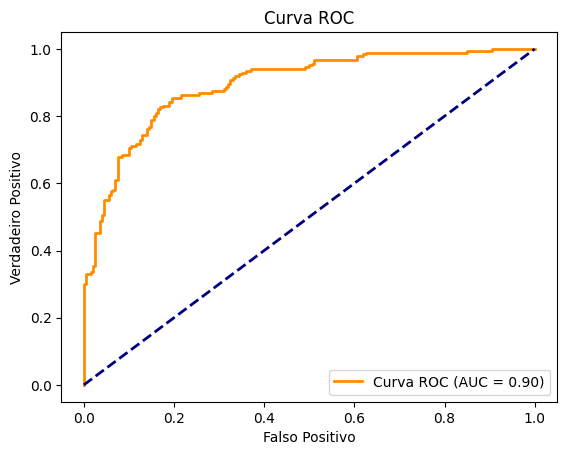

In [105]:
from sklearn.metrics import roc_curve, auc

# curva ROC e AUC
y_pred_probs = tf.nn.softmax(y_pred_logits).numpy()[:, 1] # Pega as probabilidades da classe 1

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

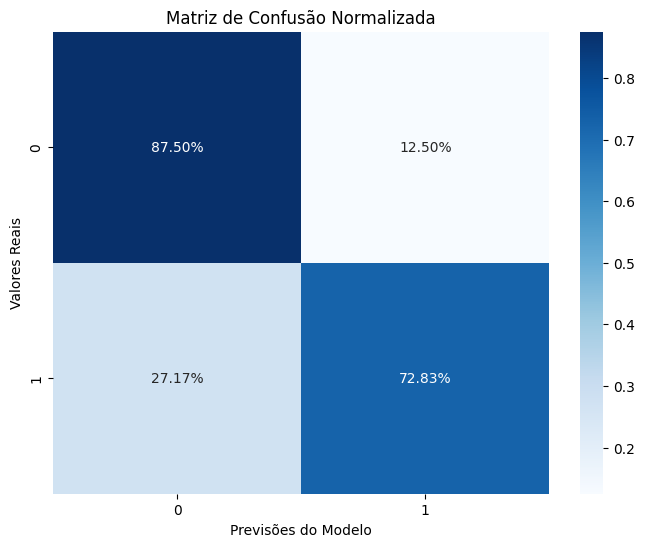

In [103]:
cm = confusion_matrix(y_true, y_pred, normalize='true')

import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Previsões do Modelo')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão Normalizada (%)')
plt.show()